In [33]:
import logging
logging.basicConfig(format='%(message)s', level=logging.INFO)
logging.getLogger('matplotlib.font_manager').disabled = True

import argparse
import logging
import os
import pprint
import threading
import time
import timeit
import traceback
import typing

os.environ["OMP_NUM_THREADS"] = "1"  # Necessary for multithreading.

import torch
from torch import multiprocessing as mp
from torch.multiprocessing import Process, Manager
from torch import nn
from torch.nn import functional as F

from torchbeast.core import file_writer
from torchbeast.core import prof
from torchbeast.core import vtrace
from torchbeast.atari_wrappers import *
from torchbeast.transformer_rnn import *
from torchbeast.train import *
from torchbeast.model import Model

import gym
import gym_sokoban
import numpy as np
from matplotlib import pyplot as plt
import logging
from collections import deque

torch.multiprocessing.set_sharing_strategy('file_system')

In [34]:
# Update to original core funct

def create_buffers(flags, obs_shape, num_actions, num_rewards) -> Buffers:
    T = flags.unroll_length
    specs = dict(
        frame=dict(size=(T + 1, *obs_shape), dtype=torch.float32),
        reward=dict(size=(T + 1, num_rewards), dtype=torch.float32),
        done=dict(size=(T + 1,), dtype=torch.bool),
        truncated_done=dict(size=(T + 1,), dtype=torch.bool),
        episode_return=dict(size=(T + 1, num_rewards), dtype=torch.float32),
        episode_step=dict(size=(T + 1,), dtype=torch.int32),
        policy_logits=dict(size=(T + 1, num_actions), dtype=torch.float32),
        im_policy_logits=dict(size=(T + 1, num_actions), dtype=torch.float32),
        reset_policy_logits=dict(size=(T + 1, 2), dtype=torch.float32),
        baseline=dict(size=(T + 1, num_rewards), dtype=torch.float32),
        last_action=dict(size=(T + 1, 3), dtype=torch.int64),
        action=dict(size=(T + 1,), dtype=torch.int64),
        im_action=dict(size=(T + 1,), dtype=torch.int64),
        reset_action=dict(size=(T + 1,), dtype=torch.int64),        
        reg_loss=dict(size=(T + 1,), dtype=torch.float32),  
        cur_t=dict(size=(T + 1,), dtype=torch.int64),             
        max_rollout_depth=dict(size=(T + 1,), dtype=torch.float32),  
    )
    buffers: Buffers = {key: [] for key in specs}
    for _ in range(flags.num_buffers):
        for key in buffers:
            buffers[key].append(torch.empty(**specs[key]).share_memory_())
    return buffers  

def act(
    flags,
    actor_index: int,
    free_queue: mp.SimpleQueue,
    full_queue: mp.SimpleQueue,
    actor_net: torch.nn.Module,
    model: torch.nn.Module,
    buffers: Buffers,
    initial_agent_state_buffers,
):
    try:
        logging.info("Actor %i started.", actor_index)
        timings = prof.Timings()  # Keep track of how fast things are.

        gym_env = ModelWrapper(SokobanWrapper(gym.make("Sokoban-v0"), noop=not flags.env_disable_noop), 
                               model=model, flags=flags)
        seed = actor_index ^ int.from_bytes(os.urandom(4), byteorder="little")
        gym_env.seed(seed)
        env = Environment(gym_env)
        env_output = env.initial()
        agent_state = actor_net.initial_state(batch_size=1)
        agent_output, unused_state = actor_net(env_output, agent_state)
        while True:
            index = free_queue.get()
            if index is None:
                break

            # Write old rollout end.
            for key in env_output:           
                if key in buffers: buffers[key][index][0, ...] = env_output[key]
            for key in agent_output:
                if key in buffers: buffers[key][index][0, ...] = agent_output[key]                    
            for i, tensor in enumerate(agent_state):
                initial_agent_state_buffers[index][i][...] = tensor

            # Do new rollout.
            for t in range(flags.unroll_length):
                timings.reset()

                with torch.no_grad():
                    agent_output, agent_state = actor_net(env_output, agent_state)                    

                timings.time("actor_net")
                
                action = torch.cat([agent_output['action'], agent_output['im_action'], agent_output['reset_action']], dim=-1)
                env_output = env.step(action.unsqueeze(0))

                if flags.trun_bs:
                    if env_output['truncated_done']: 
                        env_output['reward'] = env_output['reward'] + flags.im_discounting * agent_output['baseline']

                timings.time("step")

                for key in env_output:
                    if key in buffers:
                        #print(key, env_output[key].shape, env_output[key])
                        buffers[key][index][t + 1, ...] = env_output[key]
                for key in agent_output:
                    if key in buffers:
                        buffers[key][index][t + 1, ...] = agent_output[key]

                timings.time("write")
            full_queue.put(index)

        if actor_index == 0:
            logging.info("Actor %i: %s", actor_index, timings.summary())

    except KeyboardInterrupt:
        pass  # Return silently.
    except Exception as e:
        logging.error("Exception in worker process %i", actor_index)
        traceback.print_exc()
        print()
        raise e

def compute_policy_gradient_loss(logits_ls, actions_ls, advantages_ls, masks_ls):
    loss = 0.
    for logits, actions, advantages, masks in zip(logits_ls, actions_ls, advantages_ls, masks_ls):
        cross_entropy = F.nll_loss(
            F.log_softmax(torch.flatten(logits, 0, 1), dim=-1),
            target=torch.flatten(actions, 0, 1),
            reduction="none",)
        cross_entropy = cross_entropy.view_as(advantages)
        adv_cross_entropy = cross_entropy * advantages.detach()
        loss = loss + torch.sum(adv_cross_entropy * (1-masks))
    return loss  

def compute_entropy_loss(logits_ls, masks_ls, c_ls):
    """Return the entropy loss, i.e., the negative entropy of the policy."""
    loss = 0.
    for logits, masks, c in zip(logits_ls, masks_ls, c_ls):
        policy = F.softmax(logits, dim=-1)
        log_policy = F.log_softmax(logits, dim=-1)
        ent = torch.sum(policy * log_policy, dim=-1) #* (1-masks)
        loss = loss + torch.sum(ent) * c 
    return loss

def action_log_probs(policy_logits, actions):
    return -F.nll_loss(
        F.log_softmax(torch.flatten(policy_logits, 0, -2), dim=-1),
        torch.flatten(actions),
        reduction="none",
    ).view_as(actions) 
  
def from_logits(
    behavior_logits_ls, target_logits_ls, actions_ls, masks_ls,
    discounts, rewards, values, bootstrap_value, clip_rho_threshold=1.0,
    clip_pg_rho_threshold=1.0, lamb=1.0,):
    """V-trace for softmax policies."""
    
    log_rhos = 0.
    
    for behavior_logits, target_logits, actions, masks in zip(behavior_logits_ls, 
             target_logits_ls, actions_ls, masks_ls):
        behavior_log_probs = action_log_probs(behavior_logits, actions)        
        target_log_probs = action_log_probs(target_logits, actions)
        log_rho = target_log_probs - behavior_log_probs
        log_rhos = log_rhos + log_rho * (1-masks)
    
    vtrace_returns = vtrace.from_importance_weights(
        log_rhos=log_rhos,
        discounts=discounts,
        rewards=rewards,
        values=values,
        bootstrap_value=bootstrap_value,
        clip_rho_threshold=clip_rho_threshold,
        clip_pg_rho_threshold=clip_pg_rho_threshold,
        lamb=lamb
    )
    return vtrace.VTraceFromLogitsReturns(
        log_rhos=log_rhos,
        behavior_action_log_probs=None,
        target_action_log_probs=None,
        **vtrace_returns._asdict(),
    )  
  
def learn(
    flags,
    actor_model,
    model,
    batch,
    initial_agent_state,
    optimizer,
    scheduler,
    lock=threading.Lock(),  # noqa: B008
):
    """Performs a learning (optimization) step."""
    with lock:        
        learner_outputs, unused_state = model(batch, initial_agent_state)
        #learner_outputs["im_policy_logits"].register_hook(lambda grad: grad / (flags.rec_t - 1))
        #learner_outputs["reset_policy_logits"].register_hook(lambda grad: grad / (flags.rec_t - 1))
        #learner_outputs["baseline"].register_hook(lambda grad: grad / (flags.rec_t - 1))
        
        # Take final value function slice for bootstrapping.
        bootstrap_value = learner_outputs["baseline"][-1]        

        # Move from obs[t] -> action[t] to action[t] -> obs[t].
        batch = {key: tensor[1:] for key, tensor in batch.items()}
        learner_outputs = {key: tensor[:-1] for key, tensor in learner_outputs.items()}

        rewards = batch["reward"]
        if flags.reward_clipping > 0:
            clipped_rewards = torch.clamp(rewards, -flags.reward_clipping, flags.reward_clipping)
        else:
            clipped_rewards = rewards
        
        # compute advantage w.r.t real rewards
        
        discounts = (~batch["done"]).float() * flags.im_discounting        
        behavior_logits_ls = [batch["policy_logits"], batch["im_policy_logits"], batch["reset_policy_logits"]]
        target_logits_ls = [learner_outputs["policy_logits"], learner_outputs["im_policy_logits"], learner_outputs["reset_policy_logits"]]
        actions_ls = [batch["action"], batch["im_action"], batch["reset_action"]]        
        im_mask = (batch["cur_t"] == 0).float()
        real_mask = 1 - im_mask
        masks_ls = [real_mask, im_mask, im_mask]        

        vtrace_returns = from_logits(
            behavior_logits_ls, target_logits_ls, actions_ls, masks_ls,
            discounts=discounts,
            rewards=clipped_rewards[:, :, 0],
            values=learner_outputs["baseline"][:, :, 0],
            bootstrap_value=bootstrap_value[:, 0],
            lamb=flags.lamb
        )
        
        advantages_ls = [vtrace_returns.pg_advantages, vtrace_returns.pg_advantages, vtrace_returns.pg_advantages]
        pg_loss = compute_policy_gradient_loss(target_logits_ls, actions_ls, advantages_ls, masks_ls)         
        baseline_loss = flags.baseline_cost * compute_baseline_loss(
            vtrace_returns.vs - learner_outputs["baseline"][:, :, 0])        
       
        # compute advantage w.r.t imagainary rewards
        
        cs_ls = [flags.entropy_cost, flags.im_entropy_cost, flags.reset_entropy_cost]
        entropy_loss = compute_entropy_loss(target_logits_ls, masks_ls, cs_ls)        

        if flags.reward_type == 1:
            if flags.reward_carry:                
                discounts = (~batch["done"]).float() * flags.im_discounting 
            else:
                discounts = (~(batch["cur_t"] == 0)).float() * flags.im_discounting        
            behavior_logits_ls = [batch["im_policy_logits"], batch["reset_policy_logits"]]
            target_logits_ls = [learner_outputs["im_policy_logits"], learner_outputs["reset_policy_logits"]]
            actions_ls = [batch["im_action"], batch["reset_action"]] 
            im_mask = (batch["cur_t"] == 0).float()
            masks_ls = [im_mask, im_mask]  
            
            vtrace_returns = from_logits(
                behavior_logits_ls, target_logits_ls, actions_ls, masks_ls,
                discounts=discounts,
                rewards=clipped_rewards[:, :, 1],
                values=learner_outputs["baseline"][:, :, 1],
                bootstrap_value=bootstrap_value[:, 1],
                lamb=flags.lamb
            )
            advantages_ls = [vtrace_returns.pg_advantages, vtrace_returns.pg_advantages]
            im_pg_loss = compute_policy_gradient_loss(target_logits_ls, actions_ls, advantages_ls, masks_ls)   
            im_baseline_loss = flags.baseline_cost * compute_baseline_loss(
                vtrace_returns.vs - learner_outputs["baseline"][:, :, 1])     

        reg_loss = flags.reg_cost * torch.sum(learner_outputs["reg_loss"])
        total_loss = pg_loss + baseline_loss + entropy_loss + reg_loss
        
        if flags.reward_type == 1:
            total_loss = total_loss + flags.im_cost * (im_pg_loss + im_baseline_loss)
        
        episode_returns = batch["episode_return"][batch["done"]][:, 0]  
        max_rollout_depth = (batch["max_rollout_depth"][batch["cur_t"] == 0]).detach().cpu().numpy()
        max_rollout_depth = np.average(max_rollout_depth) if len (max_rollout_depth) > 0 else 0.        
        stats = {
            "episode_returns": tuple(episode_returns.detach().cpu().numpy()),
            "mean_episode_return": torch.mean(episode_returns).item(),
            "total_loss": total_loss.item(),
            "pg_loss": pg_loss.item(),
            "baseline_loss": baseline_loss.item(),
            "entropy_loss": entropy_loss.item(),
            "reg_loss": reg_loss.item(),
            "max_rollout_depth": max_rollout_depth
        }
        
        if flags.reward_type == 1:            
            im_episode_returns = batch["episode_return"][batch["cur_t"] == 0][:, 1]
            stats["im_episode_returns"] = tuple(im_episode_returns.detach().cpu().numpy())
            stats["im_pg_loss"] = im_pg_loss.item()
            stats["im_baseline_loss"] = im_baseline_loss.item()   

        optimizer.zero_grad()
        total_loss.backward()
        
        optimize_params = optimizer.param_groups[0]['params']
        if flags.grad_norm_clipping > 0:
            total_norm = nn.utils.clip_grad_norm_(optimize_params, flags.grad_norm_clipping)
        else:
            total_norm = 0.
            parameters = [p for p in optimize_params if p.grad is not None and p.requires_grad]
            for p in parameters:
                param_norm = p.grad.detach().data.norm(2)
                total_norm += param_norm.item() ** 2
            total_norm = total_norm ** 0.5
        stats["total_norm"] = total_norm
        
        optimizer.step()
        scheduler.step()

        actor_model.load_state_dict(model.state_dict())
        return stats  

# Wrap the environment with a model

def _format_frame(frame, bsz=None):
    if type(frame) == np.ndarray:
        frame = torch.from_numpy(frame).float()
    if bsz is not None:
        return frame.view((1,) + frame.shape)
    else:
        return frame.view((1, 1) + frame.shape)

class Environment:
    def __init__(self, gym_env):
        self.gym_env = gym_env
        self.episode_return = None
        self.episode_step = None

    def initial(self):
        initial_reward = torch.zeros(1, 1)
        # This supports only single-tensor actions ATM.
        initial_last_action = torch.zeros(1, 1, dtype=torch.int64)
        self.episode_return = torch.zeros(1, 1, 1)
        self.episode_step = torch.zeros(1, 1, dtype=torch.int32)
        initial_done = torch.ones(1, 1, dtype=torch.bool)
        initial_frame = _format_frame(self.gym_env.reset())
        return dict(
            frame=initial_frame,
            reward=initial_reward,
            done=initial_done,
            truncated_done=torch.tensor(0).view(1, 1).bool(),
            episode_return=self.episode_return,
            episode_step=self.episode_step,
            cur_t=torch.tensor(0).view(1, 1),
            last_action=initial_last_action,
        )

    def step(self, action):
        frame, reward, done, unused_info = self.gym_env.step(action[0,0].cpu().detach().numpy())     
        self.episode_step += 1
        self.episode_return = self.episode_return + torch.tensor(reward).unsqueeze(0).unsqueeze(0)
        episode_step = self.episode_step
        episode_return = self.episode_return.clone()
        if done:
            frame = self.gym_env.reset()
            self.episode_return = torch.zeros(1, 1, 1)
            self.episode_step = torch.zeros(1, 1, dtype=torch.int32)        
        frame = _format_frame(frame)
        reward = torch.tensor(reward).view(1, 1, -1)
        done = torch.tensor(done).view(1, 1)
        truncated_done = 'TimeLimit.truncated' in unused_info and unused_info['TimeLimit.truncated']
        truncated_done = torch.tensor(truncated_done).view(1, 1)
        cur_t = torch.tensor(unused_info["cur_t"]).view(1, 1)
        if cur_t == 0 and self.episode_return.shape[2] > 1:
            self.episode_return[:, :, 1] = 0.
        if 'max_rollout_depth' in unused_info:
            max_rollout_depth = torch.tensor(unused_info["max_rollout_depth"]).view(1, 1)
        else:
            max_rollout_depth = torch.tensor(0.).view(1, 1)
        
        return dict(
            frame=frame,
            reward=reward,
            done=done,
            truncated_done=truncated_done,          
            episode_return=episode_return,
            episode_step=episode_step,
            cur_t=cur_t,
            last_action=action,
            max_rollout_depth=max_rollout_depth
        )

    def close(self):
        self.gym_env.close()

    def clone_state(self):
        state = self.gym_env.clone_state()
        state["env_episode_return"] = self.episode_return.clone()
        state["env_episode_step"] = self.episode_step.clone()
        return state
        
    def restore_state(self, state):
        self.episode_return = state["env_episode_return"].clone()
        self.episode_step = state["env_episode_step"].clone()
        self.gym_env.restore_state(state)
        
class Vec_Environment:
    # deprecated
    def __init__(self, gym_env, bsz):
        self.gym_env = gym_env
        self.bsz = bsz
        self.episode_return = torch.zeros(1, self.bsz)
        self.episode_step = torch.zeros(1, self.bsz)        

    def initial(self):
        initial_reward = torch.zeros(1, self.bsz, 1)
        # This supports only single-tensor actions ATM.
        initial_last_action = torch.zeros(1, self.bsz, dtype=torch.int64)
        self.episode_return = torch.zeros(1, self.bsz)
        self.episode_step = torch.zeros(1, self.bsz, dtype=torch.int32)
        initial_done = torch.ones(1, self.bsz, dtype=torch.uint8)
        initial_frame = _format_frame(self.gym_env.reset(), self.bsz)
        cur_t = torch.zeros(1, self.bsz)
        
        return dict(
            frame=initial_frame,
            reward=initial_reward,
            done=initial_done,
            episode_return=self.episode_return,
            episode_step=self.episode_step,
            cur_t=cur_t,
            last_action=initial_last_action,
        )

    def step(self, action):
        frame, reward, done, unused_info = self.gym_env.step(action.detach().cpu().numpy())   
        
        self.episode_step += 1
        self.episode_return += torch.Tensor(reward).unsqueeze(0)
        
        done = torch.tensor(done).view(1, self.bsz)
        truncated_done = ['TimeLimit.truncated' in x and x['TimeLimit.truncated'] for x in unused_info]
        truncated_done = torch.tensor(truncated_done).view(1, self.bsz)
        
        self.episode_return = (~done).float().unsqueeze(-1) * self.episode_return
        self.episode_step = (~done).float() * self.episode_step
        
        frame = _format_frame(frame, self.bsz)
        reward = torch.tensor(reward).view(1, self.bsz).float()
        
        cur_t = [x["cur_t"] for x in unused_info]  
        cur_t = torch.tensor(cur_t).view(1, self.bsz)
        
        return dict(
            frame=frame,
            reward=reward,
            done=done,
            truncated_done=truncated_done,
            episode_return=self.episode_return,
            episode_step=self.episode_step,
            cur_t=cur_t,
            last_action=action.unsqueeze(0),
        )
    
    def clone_state(self):        
        state = {}
        state["env_episode_return"] = self.episode_return.clone()
        state["env_episode_step"] = self.episode_step.clone()
        for n, k in enumerate(self.gym_env.envs): 
            state["env_%d"%n] = k.clone_state()
        return state
        
    def restore_state(self, state):
        self.episode_return = state["env_episode_return"].clone()
        self.episode_step = state["env_episode_step"].clone()
        for n, k in enumerate(self.gym_env.envs): 
            k.restore_state(state["env_%d"%n])

    def close(self):
        self.gym_env.close()  

class Actor_net(nn.Module):    
    def __init__(self, obs_shape, num_actions, flags):

        super(Actor_net, self).__init__()
        self.obs_shape = obs_shape
        self.num_actions = num_actions  
        
        self.tran_t = flags.tran_t                   # number of recurrence of RNN
        self.tran_mem_n = flags.tran_mem_n           # size of memory for the attn modules
        self.tran_layer_n = flags.tran_layer_n       # number of layers
        self.tran_lstm = flags.tran_lstm             # to use lstm or not
        self.tran_lstm_no_attn = flags.tran_lstm_no_attn  # to use attention in lstm or not
        self.tran_norm_first = flags.tran_norm_first # to use norm first in transformer (not on LSTM)
        self.tran_ff_n = flags.tran_ff_n             # number of dim of ff in transformer (not on LSTM)        
        self.tran_skip = flags.tran_skip             # whether to add skip connection
        self.conv_out = flags.tran_dim               # size of transformer / LSTM embedding dim
        self.no_mem = flags.no_mem
        self.num_rewards = flags.num_rewards
        
        self.conv_out_hw = 1   
        self.d_model = self.conv_out
        
        self.conv1 = nn.Conv2d(in_channels=self.obs_shape[0], out_channels=self.conv_out//2, kernel_size=1, stride=1)        
        self.conv2 = nn.Conv2d(in_channels=self.conv_out//2, out_channels=self.conv_out, kernel_size=1, stride=1)        
        self.frame_conv = torch.nn.Sequential(self.conv1, nn.ReLU(), self.conv2, nn.ReLU())
        self.env_input_size = self.conv_out
        d_in = self.env_input_size + self.d_model 
        
        if self.tran_lstm:
            self.core = ConvAttnLSTM(h=self.conv_out_hw, w=self.conv_out_hw,
                                 input_dim=d_in-self.d_model, hidden_dim=self.d_model,
                                 kernel_size=1, num_layers=self.tran_layer_n,
                                 num_heads=8, mem_n=self.tran_mem_n, attn=not self.tran_lstm_no_attn)
        else:            
            self.core = ConvTransformerRNN(d_in=d_in,
                                       h=self.conv_out_hw, w=self.conv_out_hw, d_model=self.d_model, 
                                       num_heads=8, dim_feedforward=self.tran_ff_n, 
                                       mem_n=self.tran_mem_n, norm_first=self.tran_norm_first,
                                       num_layers=self.tran_layer_n, rpos=True, conv=False)   
                         
        
        if self.tran_skip:
            rnn_out_size = self.conv_out_hw * self.conv_out_hw * (self.d_model + self.env_input_size)
        else:
            rnn_out_size = self.conv_out_hw * self.conv_out_hw * self.d_model
                
        self.fc = nn.Linear(rnn_out_size, 256)        
        
        self.im_policy = nn.Linear(256, self.num_actions)        
        self.policy = nn.Linear(256, self.num_actions)        
        self.baseline = nn.Linear(256, self.num_rewards)        
        self.reset = nn.Linear(256, 2)        
        
        print("actor size: ", sum(p.numel() for p in self.parameters()))
        #for k, v in self.named_parameters(): print(k, v.numel())   

    def initial_state(self, batch_size):
        state = self.core.init_state(batch_size) + (torch.zeros(1, batch_size, 
               self.env_input_size, self.conv_out_hw, self.conv_out_hw),)
        return state

    def forward(self, obs, core_state=(), debug=False):
        # one-step forward for the actor
        # input / done shape x: T x B x C x 1 x 1 / B x C x 1 x 1
        # only supports T = 1 at the moment; all output does not have T dim.        
        
        x = obs["frame"]
        done = obs["done"]
        
        if len(x.shape) == 4: x = x.unsqueeze(0)
        if len(done.shape) == 1: done = done.unsqueeze(0)  
            
        T, B, *_ = x.shape
        x = torch.flatten(x, 0, 1)  # Merge time and batch.  
        env_input = self.frame_conv(x)                
        core_input = env_input.view(T, B, -1, self.conv_out_hw, self.conv_out_hw)
        core_output_list = []
        notdone = ~(done.bool())
        
        for n, (input, nd) in enumerate(zip(core_input.unbind(), notdone.unbind())):       
            if self.no_mem and obs["cur_t"][n, 0] == 0:
                core_state = self.initial_state(B)
                core_state = tuple(v.to(x.device) for v in core_state)
                
            # Input shape: B, self.conv_out + self.num_actions + 1, H, W
            for t in range(self.tran_t):                
                if t > 0: nd = torch.ones(B).to(x.device).bool()                    
                nd = nd.view(-1)      
                output, core_state = self.core(input, core_state, nd, nd) # output shape: 1, B, core_output_size 
                
            last_input = input   
            core_output_list.append(output)
                                   
        core_output = torch.cat(core_output_list)  
        if self.tran_skip: core_output = torch.concat([core_output, core_input], dim=-3)
        core_output = torch.flatten(core_output, 0, 1)        
        core_output = F.relu(self.fc(torch.flatten(core_output, start_dim=1)))   
        
        policy_logits = self.policy(core_output)
        im_policy_logits = self.im_policy(core_output)
        reset_policy_logits = self.reset(core_output)
        
        action = torch.multinomial(F.softmax(policy_logits, dim=1), num_samples=1)
        im_action = torch.multinomial(F.softmax(im_policy_logits, dim=1), num_samples=1)
        reset_action = torch.multinomial(F.softmax(reset_policy_logits, dim=1), num_samples=1)
                
        baseline = self.baseline(core_output)
                   
        reg_loss = (1e-3 * torch.sum(policy_logits**2, dim=-1) / 2 + 
                    1e-5 * torch.sum(core_output**2, dim=-1) / 2)
        reg_loss = reg_loss.view(T, B)
        
        policy_logits = policy_logits.view(T, B, self.num_actions)
        im_policy_logits = im_policy_logits.view(T, B, self.num_actions)
        reset_policy_logits = reset_policy_logits.view(T, B, 2)
        
        action = action.view(T, B)      
        im_action = im_action.view(T, B)      
        reset_action = reset_action.view(T, B)             
        baseline = baseline.view(T, B, self.num_rewards)
        
        ret_dict = dict(policy_logits=policy_logits,                         
                        im_policy_logits=im_policy_logits,                         
                        reset_policy_logits=reset_policy_logits,     
                        action=action,     
                        im_action=im_action,
                        reset_action=reset_action,
                        baseline=baseline, 
                        reg_loss=reg_loss, )
        
        return (ret_dict, core_state) 
    
        
class ModelWrapper(gym.Wrapper):
    def __init__(self, env, model, flags):
        gym.Wrapper.__init__(self, env)
        self.env = env
        self.model = model                
        self.rec_t = flags.rec_t        
        self.discounting = flags.discounting
        self.stat_type = flags.stat_type    
        self.reward_type = flags.reward_type    
        self.no_mem = flags.no_mem
        self.perfect_model = flags.perfect_model
        self.reset_m = flags.reset_m
        self.tree_carry = flags.tree_carry
        self.thres_carry = flags.thres_carry
        self.thres_discounting = flags.thres_discounting
        self.num_actions = env.action_space.n
        self.root_node = None
        
        # 0 for the most basic; 
        # 1 for augmented input in root stat; 
        # 2 for tree stat
        if self.stat_type == 0:
            self.use_model = self.use_model_raw
            obs_n = 5 + num_actions * 4 + self.rec_t
        elif self.stat_type == 1:            
            self.use_model = self.use_model_raw
            obs_n = 7 + num_actions * 7 + self.rec_t
        elif self.stat_type == 1.5:
            self.use_model = self.use_model_tree    
            obs_n = 6 + num_actions * 10 + self.rec_t             
        elif self.stat_type == 2:
            self.use_model = self.use_model_tree    
            obs_n = 9 + num_actions * 10 + self.rec_t   
        
        self.observation_space = gym.spaces.Box(
          low=-np.inf, high=np.inf, shape=(obs_n, 1, 1), dtype=float)
        self.model.train(False)        
        
        self.max_rollout_depth = 0.
        self.thres = None
        self.root_max_q = None
        
    def reset(self, **kwargs):
        x = self.env.reset()
        self.cur_t = 0        
        out = self.use_model(x, 0., 0, self.cur_t, 1.)
        if self.reward_type == 1:
            self.last_root_max_q = self.root_max_q
        return out.unsqueeze(-1).unsqueeze(-1)
    
    def step(self, action):  
        re_action, im_action, reset = action
        info = {}
        info["max_rollout_depth"] = self.max_rollout_depth
        if self.cur_t < self.rec_t - 1:
          self.cur_t += 1
          out = self.use_model(None, None, im_action, self.cur_t, reset)          
          if self.reward_type == 0:
            r = np.array([0.])
          else:
            r = np.array([0., (self.root_max_q - self.last_root_max_q).item()], dtype=np.float32)
          done = False
          info['cur_t'] = self.cur_t   
        else:
          self.cur_t = 0
          if self.perfect_model:
                self.env.restore_state(self.root_node.encoded)
          x, r, done, info_ = self.env.step(re_action)                    
          out = self.use_model(x, r, re_action, self.cur_t, 1., done) 
          info.update(info_)
          info['cur_t'] = self.cur_t
          if self.reward_type == 0:
            r = np.array([r])
          else:
            r = np.array([r, 0.], dtype=np.float32)   
        if self.reward_type == 1:
            self.last_root_max_q = self.root_max_q   
        
        return out.unsqueeze(-1).unsqueeze(-1), r, done, info        
        
    def use_model_raw(self, x, r, a, cur_t, reset, done):
        # mostly deprecated
        # input: 
        # r: reward - [,]; x: frame - [C, H, W]; a: action - [,]
        # cur_t: int; reset at cur_t == 0  
        with torch.no_grad():
            if cur_t == 0:
                self.rollout_depth = 0.
                if self.no_mem:
                    self.re_action = F.one_hot(torch.zeros(1, dtype=torch.long), self.num_actions)   
                else:
                    self.re_action = F.one_hot(torch.tensor(a, dtype=torch.long).unsqueeze(0), self.num_actions)                   
                
                x = torch.tensor(x, dtype=torch.float32).unsqueeze(0)
                self.x = x
                _, vs, logits, encodeds = self.model(x, self.re_action.unsqueeze(0), one_hot=True)                
                self.encoded = encodeds[-1]    
                self.encoded_reset = self.encoded.clone()
                
                if self.no_mem:
                    self.re_reward = torch.tensor([[0.]], dtype=torch.float32)                
                else:
                    self.re_reward = torch.tensor([[r]], dtype=torch.float32)                
                    
                self.v0 = vs[-1].unsqueeze(-1).clone()
                self.logit0 = logits[-1].clone()
                
                self.im_action = torch.zeros(1, self.num_actions, dtype=torch.float32)
                self.im_reset = torch.tensor([[1.]], dtype=torch.float32)
                self.im_reward = torch.zeros(1, 1, dtype=torch.float32)                                
                self.v = vs[-1].unsqueeze(-1)
                self.logit = logits[-1]
                self.rollout_first_action = torch.zeros(1, self.num_actions, dtype=torch.float32)
                self.rollout_return_wo_v = torch.zeros(1, 1, dtype=torch.float32)   
                self.rollout_return = torch.zeros(1, 1, dtype=torch.float32)                
                self.q_s_a = torch.zeros(1, self.num_actions, dtype=torch.float32)
                self.n_s_a = torch.zeros(1, self.num_actions, dtype=torch.float32)                
            else:
                self.rollout_depth += 1                
                
                self.im_action = F.one_hot(torch.tensor(a, dtype=torch.long).unsqueeze(0), self.num_actions)   
                rs, vs, logits, encodeds = self.model.forward_encoded(self.encoded, 
                   self.im_action.unsqueeze(0), one_hot=True)
                self.encoded = encodeds[-1]        
                
                self.im_reward = rs[-1].unsqueeze(-1)
                self.v = vs[-1].unsqueeze(-1)    
                self.logit = logits[-1]     
                
                if self.im_reset: 
                    # last action's reset is true; re-initialize everything                    
                    self.rollout_first_action = self.im_action.clone()
                    self.rollout_return_wo_v = torch.zeros(1, 1, dtype=torch.float32)   
                    self.rollout_depth = 1                      
                    
                self.rollout_return_wo_v += (self.discounting ** (self.rollout_depth-1)) * self.im_reward
                self.rollout_return = self.rollout_return_wo_v + (
                    self.discounting ** (self.rollout_depth)) * self.v                    
                    
                self.im_reset = torch.tensor([[reset]], dtype=torch.float32)
                if self.im_reset:                    
                    rollout_first_action_label = torch.argmax(self.rollout_first_action, dim=1)                    
                    q = self.q_s_a[:, rollout_first_action_label]
                    n = self.n_s_a[:, rollout_first_action_label]                    
                    ret = self.rollout_return[:, 0]
                    self.n_s_a[:, rollout_first_action_label] += 1                    
                    self.q_s_a[:, rollout_first_action_label] = (n * q) / (n + 1) + ret / (n + 1)
                    
        time = F.one_hot(torch.tensor([cur_t]).long(), self.rec_t)
        depc = torch.tensor([[self.discounting ** (self.rollout_depth-1)]])
        ret_dict = {"re_action": self.re_action,
                    "re_reward": self.re_reward,
                    "v0": self.v0,
                    "logit0": self.logit0,
                    "im_action": self.im_action,
                    "im_reset": self.im_reset,
                    "im_reward": self.im_reward,
                    "v": self.v,
                    "logit": self.logit,
                    "rollout_first_action": self.rollout_first_action,
                    "rollout_return": self.rollout_return,
                    "n_s_a": self.n_s_a,
                    "q_s_a": self.q_s_a,
                    "time": time,
                    "depc": depc}        
        self.ret_dict = ret_dict
        if self.stat_type == 1:
            out = torch.concat(list(ret_dict.values()), dim=-1)   
        else:
            core_inputs = ["re_action", "re_reward", "v0", "logit0", "im_action",
                           "im_reset", "im_reward", "v", "logit", "time"]
            out = torch.concat([ret_dict[v] for v in core_inputs], dim=-1)   
        self.encoded = reset * self.encoded_reset + (1 - reset) * self.encoded
        return out[0]      
    
    def use_model_tree(self, x, r, a, cur_t, reset, done=False):
        with torch.no_grad():
            if cur_t == 0:
                self.rollout_depth = 0.
                self.unexpand_rollout_depth = 0.
                self.pass_unexpand = False
                self.max_rollout_depth = 0.
                
                if self.root_max_q is not None:
                    self.thres = (self.root_max_q - r) / self.discounting
                    self.thres *= self.thres_discounting
                if done:
                    self.thres = None
                
                if self.no_mem:
                    re_action = 0
                    re_reward = torch.tensor([0.], dtype=torch.float32)                
                else:
                    re_action = a                
                    re_reward = torch.tensor([r], dtype=torch.float32)                
                
                x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0)
                self.x = self.x_ = x_tensor
                a_tensor = F.one_hot(torch.tensor(a, dtype=torch.long).unsqueeze(0), self.num_actions)                
                _, vs, logits, encodeds = self.model(x_tensor, a_tensor.unsqueeze(0), one_hot=True) 
                
                if self.perfect_model: 
                    encoded = self.clone_state()
                else:
                    encoded=encodeds[-1]
                
                if (not self.tree_carry or self.root_node is None or 
                    not self.root_node.children[a].expanded() or done):
                
                    self.root_node = Node(parent=None, action=re_action, logit=None, 
                                          num_actions=self.num_actions,
                                          discounting=self.discounting,
                                          rec_t=self.rec_t)
                    self.root_node.expand(r=torch.tensor([0.], dtype=torch.float32), 
                                          v=vs[-1, 0].unsqueeze(-1), logits=logits[-1, 0],
                                          encoded=encoded)
                else:
                    self.root_node = self.root_node.children[a]
                    self.root_node.expand(r=torch.tensor([0.], dtype=torch.float32), 
                                          v=vs[-1, 0].unsqueeze(-1), logits=logits[-1, 0],
                                          encoded=encoded, override=True)
                    self.parent = None
                
                self.root_node.visit()
                self.cur_node = self.root_node
                
            else:
                self.rollout_depth += 1                    
                self.max_rollout_depth = max(self.max_rollout_depth, self.rollout_depth)
                next_node = self.cur_node.children[a]
                
                if not next_node.expanded():
                    self.pass_unexpand = True
                    a_tensor = F.one_hot(torch.tensor(a, dtype=torch.long).unsqueeze(0), self.num_actions) 
                    if not self.perfect_model:
                        rs, vs, logits, encodeds = self.model.forward_encoded(self.cur_node.encoded, 
                            a_tensor.unsqueeze(0), one_hot=True)
                        next_node.expand(r=rs[-1, 0].unsqueeze(-1), v=vs[-1, 0].unsqueeze(-1), 
                                     logits=logits[-1, 0], encoded=encodeds[-1])
                    else:                        
                        if "done" not in self.cur_node.encoded:                            
                            self.env.restore_state(self.cur_node.encoded)                        
                            x, r, done, info = self.env.step(a)                        
                            encoded = self.env.clone_state()
                            if done: encoded["done"] = True                        
                            x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0)
                            self.x_ = x_tensor
                            a_tensor = F.one_hot(torch.tensor(a, dtype=torch.long).unsqueeze(0), self.num_actions) 
                            _, vs, logits, _ = self.model(x_tensor, a_tensor.unsqueeze(0), one_hot=True)                        

                            if done:
                                v = torch.tensor([0.], dtype=torch.float32)
                            else:
                                v = vs[-1, 0].unsqueeze(-1)

                            next_node.expand(r=torch.tensor([r], dtype=torch.float32), 
                                             v=v, 
                                             logits=logits[-1, 0], 
                                             encoded=encoded)
                        else:
                            logits = torch.concat([x.logit for x in self.cur_node.children])  
                            next_node.expand(r=torch.tensor([0.], dtype=torch.float32), 
                                             v=torch.tensor([0.], dtype=torch.float32),
                                             logits=logits, 
                                             encoded=self.cur_node.encoded)                            
                            
                next_node.visit()
                self.cur_node = next_node
            
            if self.pass_unexpand:                 
                self.unexpand_rollout_depth += 1    
                if self.reset_m >= 0 and self.unexpand_rollout_depth > self.reset_m:
                    reset = True
            
            root_node_stat = self.root_node.stat()
            cur_node_stat = self.cur_node.stat()                        
            reset = torch.tensor([reset], dtype=torch.float32)
            time = F.one_hot(torch.tensor(cur_t).long(), self.rec_t)
            depc = torch.tensor([self.discounting ** (self.rollout_depth-1)])
            
            root_trail_r = self.root_node.trail_r / self.discounting
            root_rollout_q = self.root_node.rollout_q / self.discounting
            root_max_q = torch.max(torch.concat(self.root_node.rollout_qs)).unsqueeze(-1) / self.discounting
            if self.thres_carry and self.thres is not None:
                root_max_q = torch.max(root_max_q, self.thres)                
            
            ret_list = [root_node_stat, cur_node_stat, reset, time, depc]
            if self.stat_type >= 2: ret_list.extend([root_trail_r, root_rollout_q, root_max_q])            
            out = torch.concat(ret_list, dim=-1)            
            self.last_node = self.cur_node     
            
            self.root_max_q = root_max_q
            self.ret_dict = {"v0": self.root_node.ret_dict["v"].unsqueeze(0),
                             "q_s_a": self.root_node.ret_dict["child_rollout_qs_mean"].unsqueeze(0),
                             "max_q_s_a": self.root_node.ret_dict["child_rollout_qs_max"].unsqueeze(0),
                             "n_s_a": self.root_node.ret_dict["child_rollout_ns"].unsqueeze(0),
                             "logit0": self.root_node.ret_dict["child_logits"].unsqueeze(0),
                             "reset": reset}
            
            if reset:
                self.rollout_depth = 0
                self.unexpand_rollout_depth = 0.
                self.cur_node = self.root_node
                self.cur_node.visit()
                self.pass_unexpand = False
                
            return out
                
class Node:
    def __init__(self, parent, action, logit, num_actions, discounting, rec_t):        
        
        self.action = F.one_hot(torch.tensor(action).long(), num_actions) # shape (1, num_actions)        
        self.r = torch.tensor([0.], dtype=torch.float32)    
        self.v = torch.tensor([0.], dtype=torch.float32)            
        self.logit = logit # shape (1,)        
        
        self.rollout_qs = []  # list of tensors of shape (1,)
        self.rollout_n = torch.tensor([0.], dtype=torch.float32)    
        self.parent = parent
        self.children = []
        self.encoded = None 
        
        self.num_actions = num_actions
        self.discounting = discounting
        self.rec_t = rec_t        
        
        self.visited = False

    def expanded(self):
        return len(self.children) > 0

    def expand(self, r, v, logits, encoded, override=False):
        """
        First time arriving a node and so we expand it
        r, v: tensor of shape (1,)
        logits: tensor of shape (num_actions,)
        """
        if not override: assert not self.expanded()
        if override:
            self.rollout_qs = [x - self.r + r for x in self.rollout_qs]
            self.rollout_qs[0] = v * self.discounting
        self.r = r
        self.v = v
        self.encoded = encoded
        for a in range(self.num_actions):
            if not override:
                child = self.children.append(Node(self, a, logits[[a]], 
                   self.num_actions, self.discounting, self.rec_t))
            else:
                self.children[a].logit = logits[[a]]        
            
    def visit(self):
        self.trail_r = torch.tensor([0.], dtype=torch.float32)    
        self.trail_discount = 1.
        self.propagate(self.r, self.v, not self.visited)        
        self.visited = True
        
    def propagate(self, r, v, new_rollout):
        self.trail_r = self.trail_r + self.trail_discount * r
        self.trail_discount = self.trail_discount * self.discounting
        self.rollout_q = self.trail_r + self.trail_discount * v
        if new_rollout:
            self.rollout_qs.append(self.rollout_q)
            self.rollout_n = self.rollout_n + 1
        if self.parent is not None: self.parent.propagate(r, v, new_rollout)
            
    def stat(self):
        assert self.expanded()
        self.child_logits = torch.concat([x.logit for x in self.children])        
        child_rollout_qs_mean = []
        child_rollout_qs_max = []
        for x in self.children:
            if len(x.rollout_qs) > 0:                
                q_mean = torch.mean(torch.cat(x.rollout_qs), dim=-1, keepdim=True)
                q_max = torch.max(torch.cat(x.rollout_qs), dim=-1, keepdim=True)[0]
            else:
                q_mean = torch.tensor([0.], dtype=torch.float32)    
                q_max = torch.tensor([0.], dtype=torch.float32)    
            child_rollout_qs_mean.append(q_mean)
            child_rollout_qs_max.append(q_max)
        self.child_rollout_qs_mean = torch.concat(child_rollout_qs_mean)
        self.child_rollout_qs_max = torch.concat(child_rollout_qs_max)
        self.child_rollout_ns = torch.concat([x.rollout_n for x in self.children]) / self.rec_t       
            
        ret_list = ["action", "r", "v", "child_logits", "child_rollout_qs_mean",
                    "child_rollout_qs_max", "child_rollout_ns"]
        self.ret_dict = {x: getattr(self, x) for x in ret_list}
        out = torch.concat(list(self.ret_dict.values()))        
        return out        

In [31]:
def define_parser():

    parser = argparse.ArgumentParser(description="PyTorch Scalable Agent")

    parser.add_argument("--env", type=str, default="Sokoban-v0",
                        help="Gym environment.")
    parser.add_argument("--env_disable_noop", action="store_true",
                        help="Disable noop in environment or not. (sokoban only)")

    parser.add_argument("--xpid", default=None,
                        help="Experiment id (default: None).")

    parser.add_argument("--disable_checkpoint", action="store_true",
                        help="Disable saving checkpoint.")
    parser.add_argument("--load_checkpoint", default="",
                        help="Load checkpoint directory.")    
    parser.add_argument("--savedir", default="~/RS/thinker/logs/torchbeast",
                        help="Root dir where experiment data will be saved.")

    # Training settings.        
    parser.add_argument("--num_actors", default=48, type=int, metavar="N",
                        help="Number of actors (default: 48).")
    parser.add_argument("--total_steps", default=500000000, type=int, metavar="T",
                        help="Total environment steps to train for.")
    parser.add_argument("--batch_size", default=32, type=int, metavar="B",
                        help="Learner batch size.")
    parser.add_argument("--unroll_length", default=100, type=int, metavar="T",
                        help="The unroll length (time dimension).")
    parser.add_argument("--num_buffers", default=None, type=int,
                        metavar="N", help="Number of shared-memory buffers.")
    parser.add_argument("--num_learner_threads", "--num_threads", default=1, type=int,
                        metavar="N", help="Number learner threads.")
    parser.add_argument("--disable_cuda", action="store_true",
                        help="Disable CUDA.")

    # Architecture settings
    parser.add_argument("--tran_dim", default=64, type=int, metavar="N",
                        help="Size of transformer hidden dim.")
    parser.add_argument("--tran_mem_n", default=5, type=int, metavar="N",
                        help="Size of transformer memory.")
    parser.add_argument("--tran_layer_n", default=3, type=int, metavar="N",
                        help="Number of transformer layer.")
    parser.add_argument("--tran_t", default=1, type=int, metavar="T",
                        help="Number of recurrent step for transformer.")
    parser.add_argument("--tran_ff_n", default=256, type=int, metavar="N",
                        help="Size of transformer ff .")
    parser.add_argument("--tran_skip", action="store_true",
                        help="Whether to enable skip conn.")
    parser.add_argument("--tran_norm_first", action="store_true",
                        help="Whether to use norm first in transformer.")
    parser.add_argument("--tran_rpos", action="store_true",
                        help="Whether to use relative position in transformer.")
    parser.add_argument("--tran_lstm", action="store_true",
                        help="Whether to use LSTM-transformer.")
    parser.add_argument("--tran_lstm_no_attn", action="store_true",
                        help="Whether to disable attention in LSTM-transformer.")
    parser.add_argument("--tran_erasep", action="store_true",
                        help="Whether to erase past memories if not planning.")
    
    # Loss settings.
    parser.add_argument("--entropy_cost", default=0.0001,
                        type=float, help="Entropy cost/multiplier.")
    parser.add_argument("--im_entropy_cost", default=0.0001,
                        type=float, help="Imagainary Entropy cost/multiplier.")   
    parser.add_argument("--reset_entropy_cost", default=0.0001,
                        type=float, help="Reset Entropy cost/multiplier.")       
    parser.add_argument("--baseline_cost", default=0.5,
                        type=float, help="Baseline cost/multiplier.")
    parser.add_argument("--reg_cost", default=0.1,
                        type=float, help="Reg cost/multiplier.")
    parser.add_argument("--im_cost", default=1,
                        type=float, help="Imaginary reward cost/multiplier.")    
    parser.add_argument("--discounting", default=0.99,
                        type=float, help="Discounting factor.")
    parser.add_argument("--lamb", default=1.,
                        type=float, help="Lambda when computing trace.")
    parser.add_argument("--reward_clipping", default=10, type=int, 
                        metavar="N", help="Reward clipping.")
    parser.add_argument("--trun_bs", action="store_true",
                        help="Whether to add baseline as reward when truncated.")
    
    # Model settings
    parser.add_argument("--reward_type", default=1, type=int, metavar="N",
                        help="Reward type")   
    parser.add_argument("--reset_m", default=-1, type=int, metavar="N",
                        help="Auto reset after passing m node since an unexpanded noded")    
    parser.add_argument("--model_type_nn", default=0,
                        type=float, help="Model type.")     
    parser.add_argument("--perfect_model", action="store_true",
                        help="Whether to use perfect model.")    
    parser.add_argument("--rec_t", default=5, type=int, metavar="N",
                        help="Number of planning steps.")
    parser.add_argument("--stat_type", default=1, type=int, metavar="N",
                        help="Staistic type (0: raw; 1: root node stat; 2. root & current node stat).")    
    parser.add_argument("--no_mem", action="store_true",
                        help="Whether to erase all memories after each real action.")   
    parser.add_argument("--tree_carry", action="store_true",
                        help="Whether to carry over the tree.")   
    parser.add_argument("--thres_carry", action="store_true",
                        help="Whether to carry threshold over.")   
    parser.add_argument("--reward_carry", action="store_true",
                        help="Whether to carry planning reward over.")      
    parser.add_argument("--thres_discounting", default=0.99,
                        type=float, help="Threshold discounting factor.")    
    

    # Optimizer settings.
    parser.add_argument("--learning_rate", default=0.00005,
                        type=float, metavar="LR", help="Learning rate.")
    parser.add_argument("--disable_adam", action="store_true",
                        help="Use Aadm optimizer or not.")
    parser.add_argument("--alpha", default=0.99, type=float,
                        help="RMSProp smoothing constant.")
    parser.add_argument("--momentum", default=0, type=float,
                        help="RMSProp momentum.")
    parser.add_argument("--epsilon", default=0.01, type=float,
                        help="RMSProp epsilon.")
    parser.add_argument("--grad_norm_clipping", default=0.0, type=float,
                        help="Global gradient norm clip.")
    # yapf: enable

    return parser

parser = define_parser()
flags = parser.parse_args([])        

flags.xpid = None
flags.load_checkpoint = ""

flags.env = "Sokoban-v0"
flags.num_actors = 1
flags.batch_size = 32
flags.unroll_length = 200
flags.learning_rate = 0.0001
flags.grad_norm_clipping = 60

flags.entropy_cost = 0.0001
flags.im_entropy_cost = 0.0001
flags.reset_entropy_cost = 0.0001
flags.reg_cost = 0.01
flags.im_cost = 1
flags.discounting = 0.97
flags.lamb = 1.

flags.trun_bs = False
flags.total_steps = 500000000
flags.disable_adam = False

flags.tran_t = 1
flags.tran_mem_n = 5
flags.tran_layer_n = 3
flags.tran_lstm = True
flags.tran_lstm_no_attn = False
flags.tran_norm_first = False
flags.tran_ff_n = 256
flags.tran_skip = False
flags.tran_erasep = False
flags.tran_dim = 64
flags.tran_rpos = True

flags.no_mem = True
flags.rec_t = 5
flags.model_type_nn = 0
flags.perfect_model = True
flags.stat_type = 2
flags.reward_type = 1

flags.reset_m = -1
flags.tree_carry = True
flags.thres_carry = True
flags.reward_carry = True
flags.thres_discounting = 0.97

flags.savedir = "~/tmp"

In [32]:
if flags.reward_type == 0:
    flags.num_rewards = num_rewards = 1
else:
    flags.num_rewards = num_rewards = 2
flags.im_discounting = flags.discounting ** (1/flags.rec_t)    
    
raw_env = SokobanWrapper(gym.make("Sokoban-v0"), noop=not flags.env_disable_noop)
raw_obs_shape, num_actions = raw_env.observation_space.shape, raw_env.action_space.n 

model = Model(flags, raw_obs_shape, num_actions=num_actions)
checkpoint = torch.load("../models/model_1.tar")
model.load_state_dict(checkpoint["model_state_dict"])    

env = Environment(ModelWrapper(SokobanWrapper(gym.make("Sokoban-v0"), noop=not flags.env_disable_noop), 
     model=model, flags=flags))
obs_shape = env.gym_env.observation_space.shape

mp.set_sharing_strategy('file_system')

if flags.load_checkpoint:
    flags.savedir = os.path.split(os.path.split(flags.load_checkpoint)[0])[0]
    flags.xpid = os.path.split(os.path.split(flags.load_checkpoint)[0])[-1]    
else:
    if flags.xpid is None:
        flags.xpid = "torchbeast-%s" % time.strftime("%Y%m%d-%H%M%S")
plogger = file_writer.FileWriter(
    xpid=flags.xpid, xp_args=flags.__dict__, rootdir=flags.savedir
)

flags.device = None
if not flags.disable_cuda and torch.cuda.is_available():
    logging.info("Using CUDA.")
    flags.device = torch.device("cuda")
else:
    logging.info("Not using CUDA.")
    flags.device = torch.device("cpu")

checkpointpath = os.path.expandvars(
    os.path.expanduser("%s/%s/%s" % (flags.savedir, flags.xpid, "model.tar"))
)

if flags.num_buffers is None:  # Set sensible default for num_buffers.
    flags.num_buffers = max(2 * flags.num_actors, flags.batch_size)
if flags.num_actors >= flags.num_buffers:
    raise ValueError("num_buffers should be larger than num_actors")
if flags.num_buffers < flags.batch_size:
    raise ValueError("num_buffers should be larger than batch_size")

T = flags.unroll_length
B = flags.batch_size

actor_net = Actor_net(obs_shape, num_actions, flags)
buffers = create_buffers(flags, obs_shape, num_actions, num_rewards)

if flags.load_checkpoint:
    train_checkpoint = torch.load(flags.load_checkpoint)
    actor_net.load_state_dict(train_checkpoint["model_state_dict"])  

actor_net.share_memory()

# Add initial RNN state.
initial_agent_state_buffers = []
for _ in range(flags.num_buffers):
    state = actor_net.initial_state(batch_size=1)
    for t in state:
        t.share_memory_()
    initial_agent_state_buffers.append(state)

actor_processes = []
ctx = mp.get_context()
free_queue = ctx.SimpleQueue()
full_queue = ctx.SimpleQueue()

for i in range(flags.num_actors):
    actor = ctx.Process(target=act, args=(flags, i, free_queue, full_queue,
            actor_net, model, buffers, initial_agent_state_buffers,),)
    actor.start()
    actor_processes.append(actor)

learner_net = Actor_net(obs_shape, num_actions, flags)
if flags.load_checkpoint:
    learner_net.load_state_dict(train_checkpoint["model_state_dict"])
learner_net = learner_net.to(device=flags.device)  

if not flags.disable_adam:
    print("Using Adam...")        
    optimizer = torch.optim.Adam(learner_net.parameters(),lr=flags.learning_rate)
else:
    print("Using RMS Prop...")
    optimizer = torch.optim.RMSprop(
        learner_net.actor.parameters(),
        lr=flags.learning_rate,
        momentum=flags.momentum,
        eps=flags.epsilon,
        alpha=flags.alpha,)
    
if flags.load_checkpoint:
    optimizer.load_state_dict(train_checkpoint["optimizer_state_dict"])    
    
print("All parameters: ")
for k, v in learner_net.named_parameters(): print(k, v.numel())    

def lr_lambda(epoch):
    return 1 - min(epoch * T * B, flags.total_steps) / flags.total_steps

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
if flags.load_checkpoint:
    scheduler.load_state_dict(train_checkpoint["scheduler_state_dict"])
    
logger = logging.getLogger("logfile")
stat_keys = ["mean_episode_return", "episode_returns", "total_loss",
    "pg_loss", "baseline_loss", "entropy_loss", "max_rollout_depth"]
if flags.reward_type == 1:
    stat_keys.extend(["im_pg_loss", "im_baseline_loss"])

logger.info("# Step\t%s", "\t".join(stat_keys))

step, stats, last_returns, last_im_returns, tot_eps = 0, {}, deque(maxlen=400), deque(maxlen=40000), 0
if flags.load_checkpoint:
    step = train_checkpoint["scheduler_state_dict"]["_step_count"] * T * B
    
def batch_and_learn(i, lock=threading.Lock()):
    """Thread target for the learning process."""
    #nonlocal step, stats, last_returns, tot_eps
    global step, stats, last_returns, last_im_returns, tot_eps
    timings = prof.Timings()
    while step < flags.total_steps:
        timings.reset()
        batch, agent_state = get_batch(flags, free_queue, full_queue, buffers,
            initial_agent_state_buffers, timings,)
        stats = learn(flags, actor_net, learner_net, batch, agent_state, optimizer, 
            scheduler)
        last_returns.extend(stats["episode_returns"])
        if "im_episode_returns" in stats:
            last_im_returns.extend(stats["im_episode_returns"])
        tot_eps = tot_eps + len(stats["episode_returns"])
        timings.time("learn")
        with lock:
            to_log = dict(step=step)
            to_log.update({k: stats[k] for k in stat_keys})            
            to_log.update({"rmean_im_episode_return": np.average(last_im_returns) if len(last_im_returns) > 0 else 0.,
                           "rmean_episode_return": np.average(last_returns) if len(last_returns) > 0 else 0.,
                           "episode": tot_eps})
            plogger.log(to_log)
            step += T * B

    if i == 0:
        logging.info("Batch and learn: %s", timings.summary())

for m in range(flags.num_buffers):
    free_queue.put(m)

threads = []
for i in range(flags.num_learner_threads):
    thread = threading.Thread(
        target=batch_and_learn, name="batch-and-learn-%d" % i, args=(i,)
    )
    thread.start()
    threads.append(thread)

def checkpoint():
    if flags.disable_checkpoint:
        return
    logging.info("Saving checkpoint to %s", checkpointpath)
    torch.save(
        {
            "model_state_dict": actor_net.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler_state_dict": scheduler.state_dict(),
            "flags": vars(flags),
        },
        checkpointpath,
    )

timer = timeit.default_timer
try:
    last_checkpoint_time = timer()
    while step < flags.total_steps:
        start_step = step
        start_time = timer()
        time.sleep(5)

        if timer() - last_checkpoint_time > 10 * 60:  # Save every 10 min.
            checkpoint()
            last_checkpoint_time = timer()

        sps = (step - start_step) / (timer() - start_time)
        if stats.get("episode_returns", None):
            mean_return = (
                "Return per episode: %.1f. " % stats["mean_episode_return"]
            )
        else:
            mean_return = ""
        total_loss = stats.get("total_loss", float("inf"))

        print_str =  "Steps %i @ %.1f SPS. Eps %i. L400 Return %f (%f). Loss %.2f" % (step, sps, tot_eps, 
            np.average(last_returns) if len(last_returns) > 0 else 0.,
            np.average(last_im_returns) if len(last_im_returns) > 0 else 0.,
            total_loss)

        for s in ["max_rollout_depth", "pg_loss", "baseline_loss", "im_pg_loss", 
                  "im_baseline_loss", "entropy_loss", "reg_loss", "total_norm"]:
            if s in stats: print_str += " %s %.2f" % (s, stats[s])

        logging.info(print_str)
except KeyboardInterrupt:
    for thread in threads:
        thread.join()        
    # Try joining actors then quit.
else:
    for thread in threads:
        thread.join()
    logging.info("Learning finished after %d steps.", step)
finally:
    for _ in range(flags.num_actors):
        free_queue.put(None)
    for actor in actor_processes:
        actor.join(timeout=1)

checkpoint()
plogger.close()

Creating log directory: /home/sc/tmp/torchbeast-20221117-220137
Creating log directory: /home/sc/tmp/torchbeast-20221117-220137
Creating log directory: /home/sc/tmp/torchbeast-20221117-220137
Symlinked log directory: /home/sc/tmp/latest
Symlinked log directory: /home/sc/tmp/latest
Symlinked log directory: /home/sc/tmp/latest
Saving arguments to /home/sc/tmp/torchbeast-20221117-220137/meta.json
Saving arguments to /home/sc/tmp/torchbeast-20221117-220137/meta.json
Saving arguments to /home/sc/tmp/torchbeast-20221117-220137/meta.json
Saving messages to /home/sc/tmp/torchbeast-20221117-220137/out.log
Saving messages to /home/sc/tmp/torchbeast-20221117-220137/out.log
Saving messages to /home/sc/tmp/torchbeast-20221117-220137/out.log
Saving logs data to /home/sc/tmp/torchbeast-20221117-220137/logs.csv
Saving logs data to /home/sc/tmp/torchbeast-20221117-220137/logs.csv
Saving logs data to /home/sc/tmp/torchbeast-20221117-220137/logs.csv
Saving logs' fields to /home/sc/tmp/torchbeast-20221117

actor size:  396838


Actor 0 started.
# Step	mean_episode_return	episode_returns	total_loss	pg_loss	baseline_loss	entropy_loss	max_rollout_depth	im_pg_loss	im_baseline_loss


actor size:  396838
Using Adam...
All parameters: 
conv1.weight 2048
conv1.bias 32
conv2.weight 2048
conv2.bias 64
core.layers.0.pos_w 320
core.layers.0.pos_b 40
core.layers.0.conv.weight 81920
core.layers.0.conv.bias 320
core.layers.0.proj.weight 36864
core.layers.0.proj.bias 192
core.layers.0.out.weight 4096
core.layers.0.out.bias 64
core.layers.0.norm.weight 64
core.layers.0.norm.bias 64
core.layers.1.pos_w 320
core.layers.1.pos_b 40
core.layers.1.conv.weight 81920
core.layers.1.conv.bias 320
core.layers.1.proj.weight 36864
core.layers.1.proj.bias 192
core.layers.1.out.weight 4096
core.layers.1.out.bias 64
core.layers.1.norm.weight 64
core.layers.1.norm.bias 64
core.layers.2.pos_w 320
core.layers.2.pos_b 40
core.layers.2.conv.weight 81920
core.layers.2.conv.bias 320
core.layers.2.proj.weight 36864
core.layers.2.proj.bias 192
core.layers.2.out.weight 4096
core.layers.2.out.bias 64
core.layers.2.norm.weight 64
core.layers.2.norm.bias 64
core.proj_list.0.weight 128
core.proj_list.0.bia

Steps 0 @ 0.0 SPS. Eps 0. L400 Return 0.000000 (0.000000). Loss inf
Steps 0 @ 0.0 SPS. Eps 0. L400 Return 0.000000 (0.000000). Loss inf
Steps 0 @ 0.0 SPS. Eps 0. L400 Return 0.000000 (0.000000). Loss inf
Steps 0 @ 0.0 SPS. Eps 0. L400 Return 0.000000 (0.000000). Loss inf
Steps 0 @ 0.0 SPS. Eps 0. L400 Return 0.000000 (0.000000). Loss inf
Steps 0 @ 0.0 SPS. Eps 0. L400 Return 0.000000 (0.000000). Loss inf
Steps 0 @ 0.0 SPS. Eps 0. L400 Return 0.000000 (0.000000). Loss inf
Steps 0 @ 0.0 SPS. Eps 0. L400 Return 0.000000 (0.000000). Loss inf
Steps 0 @ 0.0 SPS. Eps 0. L400 Return 0.000000 (0.000000). Loss inf
Steps 0 @ 0.0 SPS. Eps 0. L400 Return 0.000000 (0.000000). Loss inf
Steps 0 @ 0.0 SPS. Eps 0. L400 Return 0.000000 (0.000000). Loss inf
Steps 0 @ 0.0 SPS. Eps 0. L400 Return 0.000000 (0.000000). Loss inf
Steps 0 @ 0.0 SPS. Eps 0. L400 Return 0.000000 (0.000000). Loss inf
Steps 0 @ 0.0 SPS. Eps 0. L400 Return 0.000000 (0.000000). Loss inf
Steps 0 @ 0.0 SPS. Eps 0. L400 Return 0.000000 (

KeyboardInterrupt: 

In [ ]:
step = flags.total_steps + 1
for thread in threads:
     thread.join()

In [ ]:
for _ in range(flags.num_actors):
    free_queue.put(None)
for actor in actor_processes:
    actor.join(timeout=1)

<font size="5">Agent Debug and Visualize</font>

In [6]:
import matplotlib.ticker as mticker

def plot_obs(x, ax=None, title=None):
    if ax is None: fig, ax = plt.subplots()
    ax.imshow(torch.swapaxes(torch.swapaxes(x[0].cpu(),0,2),0,1), interpolation='nearest', aspect="auto")
    if title is not None: ax.set_title(title)
    
def plot_qn_sa(q_s_a, n_s_a, max_q_s_a=None, ax=None):
    if ax is None: fig, ax = plt.subplots()
    xs = np.arange(len(q_s_a))

    ax.bar(xs - 0.3, q_s_a.cpu(), color = 'g', width = 0.3, label="q_s_a")    
    ax_n = ax.twinx()
    if max_q_s_a is not None:
        ax.bar(xs, max_q_s_a.cpu(), color = 'r', width = 0.3, label="max_q_s_a")        
    ax_n.bar(xs + (0.3 if max_q_s_a is not None else 0.), 
             n_s_a.cpu(), bottom=0, color = 'b', width = 0.3, label="n_s_a")
    ax.xaxis.set_major_locator(mticker.FixedLocator(np.arange(len(q_s_a))))
    ax.set_xticklabels(('noop', 'up', 'down', 'left', 'right'))    
    ax.legend(loc="upper left")   
    ax_n.legend(loc="upper right") 
    ax.set_title("q_s_a and n_s_a")
    
def plot_policies(model_logit, actor_logit, ax=None):
    if ax is None: fig, ax = plt.subplots()
    model_prob = torch.softmax(model_logit, dim=-1).detach().cpu().numpy()
    prob = torch.softmax(actor_logit, dim=-1).detach().cpu().numpy()
    ax.set_title("Real policy prob")
    xs = np.arange(len(model_prob))
    ax.bar(xs - 0.1, model_prob, color = 'g', width = 0.1, label="model policy prob")
    ax.bar(xs, prob, color = 'r', width = 0.1, label="agent policy prob")
    ax.xaxis.set_major_locator(mticker.FixedLocator(np.arange(len(model_prob))))
    ax.set_xticklabels(('noop', 'up', 'down', 'left', 'right'))
    ax.set_ylim(0, 1)        
    ax.legend()       
        
def plot_im_policies(im_policy_logits, reset_policy_logits, im_action, reset_action, 
                     one_hot=True, reset_ind=0, ax=None):
    if ax is None: fig, ax = plt.subplots()
        
    rec_t, num_actions = im_policy_logits.shape
    num_actions += 1
    rec_t -= 1
        
    im_prob = torch.softmax(im_policy_logits, dim=-1).detach().cpu().numpy()
    reset_prob = torch.softmax(reset_policy_logits, dim=-1)[:,[reset_ind]].detach().cpu().numpy()
    im_reset_prob = np.concatenate([im_prob, reset_prob], axis=-1)
    
    if not one_hot: im_action = F.one_hot(im_action, num_actions - 1)
    im_action = im_action.detach().cpu().numpy()
    reset_action = reset_action.unsqueeze(-1).detach().cpu().numpy()    
    im_reset_action = np.concatenate([im_action, reset_action], axis=-1)
    
    im_reset_prob = im_reset_prob[:-1]
    im_reset_action = im_reset_action[:-1]
    
    xs = np.arange(rec_t)
    labels = ['noop', 'up', 'down', 'left', 'right', 'reset']
    for i in range(num_actions):        
        c = ax.bar(xs + 0.8 * (i / num_actions), im_reset_prob[:,i], width = 0.8 / (num_actions), label=labels[i])  
        color = c.patches[0].get_facecolor()
        color = color[:3] + (color[3] * 0.5,)
        ax.bar(xs + 0.8 * (i / num_actions), im_reset_action[:,i], width = 0.8 / (num_actions), color=color)
        
    
    #xs = np.arange(num_actions)
    #for i in range(rec_t):
    #    ax.bar(xs + 0.8 * (i / rec_t), im_reset_action[i], width = 0.8 / (rec_t), color="#cccccc")
    #    ax.bar(xs + 0.8 * (i / rec_t), im_reset_prob[i], width = 0.8 / (rec_t))        
    #ax.xaxis.set_major_locator(mticker.FixedLocator(np.arange(num_actions)))
    #ax.set_xticklabels(('noop', 'up', 'down', 'left', 'right', 'reset'))    
    ax.legend()
    ax.set_ylim(0, 1)   
    ax.set_title("Imagainary policy prob")
    plt.show()         
    
def print_im_actions(im_dict, print_stat=False):

    lookup_dict = {0:"Noop",
                   1:"Up",
                   2:"Down",
                   3:"Left",
                   4:"Right"}

    print_strs = []
    n, s = 1, ""
    reset = False
    for im, reset in zip(im_dict["im_action"][:-1], im_dict["reset_action"][:-1]):
        s += lookup_dict[im.item()] + ", "
        if reset:        
            s += "Reset"
            print_strs.append("%d: %s" %(n, s))
            s = ""
            n += 1
    if not reset: print_strs.append("%d: %s" %(n, s[:-2]))
    if print_stat: 
        for s in print_strs: print(s) 
    return print_strs

def plot_im_actions(im_dict, ax=None):    
    if ax is None: fig, ax = plt.subplots()
    ax.axis('off')
    print_strs = print_im_actions(im_dict, print_stat=False)
    for n, s in enumerate(print_strs):  
        txt = ax.text(0, 0.8 - 0.1 * n, s, size='x-large')        
        txt.set_clip_on(True) 
    ax.set_xlim(0,1)

In [7]:
bsz = 1

name = "alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_0.5_perfect"
checkpoint = torch.load("/home/sc/RS/thinker/logs/planner_logs/%s/model.tar" % name)

flags_ = checkpoint["flags"]

flags.tran_dim = flags_["tran_dim"]

flags.rec_t = flags_["rec_t"]
flags.tran_mem_n = flags_["tran_mem_n"]
flags.no_mem = flags_["no_mem"] 

flags.reward_type = flags_["reward_type"] 
flags.stat_type = flags_["stat_type"]
flags.perfect_model = flags_["perfect_model"]
flags.reset_m = flags_["reset_m"] if "reset_m" in flags_.keys() else -1

flags.discounting = flags_["discounting"]

if flags.reward_type == 0:
    flags.num_rewards = num_rewards = 1
else:
    flags.num_rewards = num_rewards = 2

raw_env = SokobanWrapper(gym.make("Sokoban-v0"), noop=not flags.env_disable_noop)
raw_obs_shape, num_actions = raw_env.observation_space.shape, raw_env.action_space.n 
model = Model(flags, raw_obs_shape, num_actions=num_actions)
model_checkpoint = torch.load("../models/model_1.tar")
model.load_state_dict(model_checkpoint["model_state_dict"])   

env = Environment(ModelWrapper(SokobanWrapper(gym.make("Sokoban-v0"), noop=not flags.env_disable_noop), 
     model=model, flags=flags))
obs_shape = env.gym_env.observation_space.shape

flags.device = None
if not flags.disable_cuda and torch.cuda.is_available():
    logging.info("Using CUDA.")
    flags.device = torch.device("cuda")
else:
    logging.info("Not using CUDA.")
    flags.device = torch.device("cpu")

actor_net = Actor_net(obs_shape, num_actions, flags).to(flags.device)
actor_net.load_state_dict(checkpoint["model_state_dict"])  

Using CUDA.


actor size:  398078


<All keys matched successfully>

In [ ]:
debug = True
eps_n = 1000

raw_env = SokobanWrapper(gym.make("Sokoban-v0"), noop=not flags.env_disable_noop)
raw_obs_shape, num_actions = raw_env.observation_space.shape, raw_env.action_space.n 
model = Model(flags, raw_obs_shape, num_actions=num_actions)
checkpoint = torch.load("../models/model_1.tar")
model.load_state_dict(checkpoint["model_state_dict"])  
model.train(False)
env = ModelWrapper(SokobanWrapper(gym.make("Sokoban-v0"), noop=True), model=model, flags=flags)
env = Environment(env)

core_state = actor_net.initial_state(bsz)
core_state = tuple(v.to(flags.device) for v in core_state)
returns = []
obs = env.initial()

t = 0
im_list = ["im_policy_logits", "reset_policy_logits", "im_action", "reset_action"]
im_dict = {k: [] for k in im_list}
while(True):
    if len(returns) > (0 if debug else eps_n): break    
    with torch.no_grad():
        obs = {k:v.to(flags.device) for k, v in obs.items()}                             
        actor_out, core_state = actor_net(obs, core_state, debug=False)
        action = torch.cat([actor_out['action'][0].unsqueeze(-1), 
                            actor_out['im_action'][0].unsqueeze(-1), 
                            actor_out['reset_action'][0].unsqueeze(-1)], dim=-1)
        if len(im_dict['reset_action']) > 0:
            im_dict['reset_action'][-1] = env.gym_env.ret_dict['reset'].to(flags.device)
        for k in im_list: im_dict[k].append(actor_out[k][0,0].unsqueeze(0))        
        if debug and obs["cur_t"][0,0] == (flags.rec_t - 1): 
            for k in im_list: im_dict[k] = torch.concat(im_dict[k], dim=0)
            
            fig, axs = plt.subplots(1, 4, figsize=(24,6))  
            ret_dict = env.gym_env.ret_dict
            title = "step: %d; values: %.4f" % (t, ret_dict["v0"][0].cpu())
            if flags.reward_type == 1: title += " im_return: %.4f" % obs['episode_return'][..., 1]            
            plot_obs(env.gym_env.x/255, axs[0], title=title)          
            max_q_s_a = ret_dict["max_q_s_a"][0] if "max_q_s_a" in ret_dict else None
            plot_qn_sa(ret_dict["q_s_a"][0], ret_dict["n_s_a"][0], max_q_s_a, ax=axs[2]) 
            plot_policies(ret_dict["logit0"][0], actor_out["policy_logits"][0,0], ax=axs[3])    
            plot_im_policies(**im_dict, one_hot=False, reset_ind=1, ax=axs[1])    
            plt.show()            
            print_im_actions(im_dict, print_stat=True)
            im_dict = {k: [] for k in im_list}            
        obs = env.step(action.unsqueeze(0))        
        if torch.any(obs['done']):
            new_rets = obs['episode_return'][obs['done']][:,0].numpy()
            returns.extend(new_rets)
            print("Finish %d episode: avg. return: %.2f (+-%.2f) " % (len(returns),
                np.average(returns), np.std(returns) / np.sqrt(len(returns))))  
    t += 1

In [ ]:
im_dict

In [ ]:
# Test

parser = define_parser()
flags = parser.parse_args([])        
parser = define_parser()
flags = parser.parse_args([])        

flags.xpid = None
flags.env = "Sokoban-v0"
flags.tran_lstm = True
flags.tran_lstm_no_attn = True

raw_env = SokobanWrapper(gym.make("Sokoban-v0"), noop=not flags.env_disable_noop)
raw_obs_shape, num_actions = raw_env.observation_space.shape, raw_env.action_space.n 

model = Model(flags, raw_obs_shape, num_actions=num_actions)
checkpoint = torch.load("../models/model_1.tar")
model.load_state_dict(checkpoint["model_state_dict"])    

env = Environment(ModelWrapper(SokobanWrapper(gym.make("Sokoban-v0"), noop=not flags.env_disable_noop), 
                model=model, rec_t=flags.rec_t, flags=flags))
obs = env.initial()

obs_shape, num_actions = env.gym_env.observation_space.shape, env.gym_env.action_space.n   
num_actions = env.gym_env.action_space.n
actor_net = Actor_net(obs_shape, num_actions, flags)
core_state = actor_net.initial_state(1)

for t in range(10):
  actor_out, core_state = actor_net(obs, core_state=core_state)
  action = torch.cat([actor_out['action'], actor_out['im_action'], actor_out['reset_action']], dim=-1)
  obs = env.step(action.unsqueeze(0))
  print(t, obs)


In [ ]:
num_actions = 4    
root = Node(parent=None, action=2, logit=torch.tensor([0.3]), num_actions=num_actions, discounting=0.97)
root.expand(r=torch.tensor([3.]), v=torch.tensor([2.]), logits=torch.tensor([0.3,0.4,0.5,0.6]), encoded=None)
root.visit()
cur_node = root
print(1, root.rollout_qs, root.stat())
cur_node = cur_node.children[3]
cur_node.expand(r=torch.tensor([1.]), v=torch.tensor([4.]), logits=torch.tensor([0.4,0.4,0.5,0.6]), encoded=None)
cur_node.visit()

print(2, root.rollout_qs, root.stat())
cur_node = cur_node.children[2]
cur_node.expand(r=torch.tensor([100.]), v=torch.tensor([0.]), logits=torch.tensor([0.4,0.4,0.5,0.6]), encoded=None)
cur_node.visit()
print(3, root.rollout_qs, root.stat())

root.visit()
cur_node = root
print(4, root.rollout_qs, root.stat())
cur_node = cur_node.children[3]
#cur_node.expand(r=torch.tensor([1.]), v=torch.tensor([3.]), logits=torch.tensor([0.4,0.4,0.5,0.6]), encoded=None)
cur_node.visit()

print(5, root.rollout_qs, root.stat())
cur_node = cur_node.children[1]
cur_node.expand(r=torch.tensor([-10.]), v=torch.tensor([0.]), logits=torch.tensor([0.4,0.4,0.5,0.6]), encoded=None)
cur_node.visit()
print(6, root.rollout_qs, root.stat())

flags.rec_t = 20

raw_env = SokobanWrapper(gym.make("Sokoban-v0"), noop=not flags.env_disable_noop)
raw_obs_shape, num_actions = raw_env.observation_space.shape, raw_env.action_space.n     
    
model = Model(flags, raw_obs_shape, num_actions=num_actions)
checkpoint = torch.load("../models/model_1.tar")
model.load_state_dict(checkpoint["model_state_dict"])    

env = Environment(ModelWrapper(SokobanWrapper(gym.make("Sokoban-v0"), noop=not flags.env_disable_noop), 
     model=model, flags=flags))
_ = env.initial()

act_seqs = [[2, 1, 1], [2, 2, 1], [2, 3, 1], [2, 4, 1], [2, 1, 0], [2, 2, 1]]
#act_seqs = [[2, 4, 0], [2, 1, 1], [2, 4, 0], [2, 2, 1], [2, 2, 1]]

for a in act_seqs:
    obs = env.step(torch.tensor(a).unsqueeze(0).unsqueeze(0))
    x = obs['frame'][0, 0, :, 0, 0]
    r = obs['reward'][0, 0, :]
    print("================================================")
    print("a", a[1:])
    print("x", x)
    print("r", r)
    print("rollout_qs", torch.concat(env.gym_env.root_node.rollout_qs) / flags.discounting)
    print("root stat", env.gym_env.root_node.ret_dict)
    print("last stat", env.gym_env.last_node.ret_dict)

In [ ]:
   
class ModelWrapper(gym.Wrapper):
    def __init__(self, env, model, flags):
        gym.Wrapper.__init__(self, env)
        self.env = env
        self.model = model                
        self.rec_t = flags.rec_t        
        self.discounting = flags.discounting
        self.stat_type = flags.stat_type    
        self.reward_type = flags.reward_type    
        self.no_mem = flags.no_mem
        self.num_actions = env.action_space.n
        
        # 0 for the most basic; 
        # 1 for augmented input in root stat; 
        # 2 for tree stat
        if self.stat_type == 0:
            self.use_model = self.use_model_raw
            obs_n = 5 + num_actions * 4 + self.rec_t
        elif self.stat_type == 1:            
            self.use_model = self.use_model_raw
            obs_n = 7 + num_actions * 7 + self.rec_t
        elif self.stat_type == 1.5:
            self.use_model = self.use_model_tree    
            obs_n = 6 + num_actions * 10 + self.rec_t             
        elif self.stat_type == 2:
            self.use_model = self.use_model_tree    
            obs_n = 9 + num_actions * 10 + self.rec_t         
        
        self.observation_space = gym.spaces.Box(
          low=-np.inf, high=np.inf, shape=(obs_n, 1, 1), dtype=float)
        self.model.train(False)        
        
    def reset(self, **kwargs):
        x = self.env.reset()
        self.cur_t = 0        
        out = self.use_model_raw(x, 0., 0, self.cur_t, 1.)
        out_ = self.use_model_tree(x, 0., 0, self.cur_t, 1.)
        if self.reward_type == 1:
            self.last_root_max_q = self.root_max_q
        self.max_rollout_depth = 0.
        return out, out_
    
    def step(self, action):  
        re_action, im_action, reset = action
        info = {}
        info["max_rollout_depth"] = self.max_rollout_depth
        if self.cur_t < self.rec_t - 1:
          self.cur_t += 1
          out = self.use_model_raw(None, None, im_action, self.cur_t, reset)      
          out_ = self.use_model_tree(None, None, im_action, self.cur_t, reset)      
          if self.reward_type == 0:
            r = np.array([0.])
          else:
            r = np.array([0., (self.root_max_q - self.last_root_max_q).item()], dtype=np.float32)
          done = False
          info['cur_t'] = self.cur_t   
        else:
          self.cur_t = 0
          x, r, done, info_ = self.env.step(re_action)                    
          out = self.use_model_raw(x, r, re_action, self.cur_t, 1.) 
          out_ = self.use_model_tree(x, r, re_action, self.cur_t, 1.) 
          info.update(info_)
          info['cur_t'] = self.cur_t
          if self.reward_type == 0:
            r = np.array([r])
          else:
            r = np.array([r, 0.], dtype=np.float32)   
        if self.reward_type == 1:
            self.last_root_max_q = self.root_max_q        
        return out, out_, r, done, info        
        
    def use_model_raw(self, x, r, a, cur_t, reset):
        # input: 
        # r: reward - [,]; x: frame - [C, H, W]; a: action - [,]
        # cur_t: int; reset at cur_t == 0  
        with torch.no_grad():
            if cur_t == 0:                
                self.rollout_depth_ = 0.
                if self.no_mem:
                    self.re_action = F.one_hot(torch.zeros(1, dtype=torch.long), self.num_actions)   
                else:
                    self.re_action = F.one_hot(torch.tensor(a, dtype=torch.long).unsqueeze(0), self.num_actions)                   
                
                x = torch.tensor(x, dtype=torch.float32).unsqueeze(0)
                self.x = x
                _, vs, logits, encodeds = self.model(x, self.re_action.unsqueeze(0), one_hot=True)                
                self.encoded = encodeds[-1]    
                self.encoded_reset = self.encoded.clone()
                
                if self.no_mem:
                    self.re_reward = torch.tensor([[0.]], dtype=torch.float32)                
                else:
                    self.re_reward = torch.tensor([[r]], dtype=torch.float32)                
                    
                self.v0 = vs[-1].unsqueeze(-1).clone()
                self.logit0 = logits[-1].clone()
                
                self.im_action = torch.zeros(1, self.num_actions, dtype=torch.float32)
                self.im_reset = torch.tensor([[1.]], dtype=torch.float32)
                self.im_reward = torch.zeros(1, 1, dtype=torch.float32)                                
                self.v = vs[-1].unsqueeze(-1)
                self.logit = logits[-1]
                self.rollout_first_action = torch.zeros(1, self.num_actions, dtype=torch.float32)
                self.rollout_return_wo_v = torch.zeros(1, 1, dtype=torch.float32)   
                self.rollout_return = torch.zeros(1, 1, dtype=torch.float32)                
                self.q_s_a = torch.zeros(1, self.num_actions, dtype=torch.float32)
                self.n_s_a = torch.zeros(1, self.num_actions, dtype=torch.float32)                
            else:
                self.rollout_depth_ += 1                
                
                self.im_action = F.one_hot(torch.tensor(a, dtype=torch.long).unsqueeze(0), self.num_actions)   
                rs, vs, logits, encodeds = self.model.forward_encoded(self.encoded, 
                   self.im_action.unsqueeze(0), one_hot=True)
                self.encoded = encodeds[-1]        
                
                self.im_reward = rs[-1].unsqueeze(-1)
                self.v = vs[-1].unsqueeze(-1)    
                self.logit = logits[-1]     
                
                if self.im_reset: 
                    # last action's reset is true; re-initialize everything                    
                    self.rollout_first_action = self.im_action.clone()
                    self.rollout_return_wo_v = torch.zeros(1, 1, dtype=torch.float32)   
                    self.rollout_depth_ = 1                      
                    
                self.rollout_return_wo_v += (self.discounting ** (self.rollout_depth_-1)) * self.im_reward
                self.rollout_return = self.rollout_return_wo_v + (
                    self.discounting ** (self.rollout_depth_)) * self.v   
                    
                self.im_reset = torch.tensor([[reset]], dtype=torch.float32)
                if self.im_reset:                    
                    rollout_first_action_label = torch.argmax(self.rollout_first_action, dim=1)                    
                    q = self.q_s_a[:, rollout_first_action_label]
                    n = self.n_s_a[:, rollout_first_action_label]                    
                    ret = self.rollout_return[:, 0]
                    self.n_s_a[:, rollout_first_action_label] += 1                    
                    self.q_s_a[:, rollout_first_action_label] = (n * q) / (n + 1) + ret / (n + 1)
                    
        time = F.one_hot(torch.tensor([cur_t]).long(), self.rec_t)
        depc = torch.tensor([[self.discounting ** (self.rollout_depth_-1)]])
        ret_dict = {"re_action": self.re_action,
                    "re_reward": self.re_reward,
                    "v0": self.v0,
                    "logit0": self.logit0,
                    "im_action": self.im_action,
                    "im_reset": self.im_reset,
                    "im_reward": self.im_reward,
                    "v": self.v,
                    "logit": self.logit,
                    "rollout_first_action": self.rollout_first_action,
                    "rollout_return": self.rollout_return,
                    "n_s_a": self.n_s_a / self.rec_t,
                    "q_s_a": self.q_s_a,
                    "time": time,
                    "depc": depc}        
        self.ret_dict = ret_dict
        if self.stat_type == 1:
            out = torch.concat(list(ret_dict.values()), dim=-1)   
        else:
            core_inputs = ["re_action", "re_reward", "v0", "logit0", "im_action",
                           "im_reset", "im_reward", "v", "logit", "time"]
            out = torch.concat([ret_dict[v] for v in core_inputs], dim=-1)   
        self.encoded = reset * self.encoded_reset + (1 - reset) * self.encoded
        return out[0]      
    
    def use_model_tree(self, x, r, a, cur_t, reset):
        with torch.no_grad():
            if cur_t == 0:
                self.rollout_depth = 0.
                self.max_rollout_depth = 0.
                
                if self.no_mem:
                    re_action = 0
                    re_reward = torch.tensor([0.], dtype=torch.float32)                
                else:
                    re_action = a                
                    re_reward = torch.tensor([r], dtype=torch.float32)                
                
                x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0)
                self.x = x_tensor
                a_tensor = F.one_hot(torch.tensor(re_action, dtype=torch.long).unsqueeze(0), self.num_actions)
                
                _, vs, logits, encodeds = self.model(x_tensor, a_tensor.unsqueeze(0), one_hot=True)
                
                self.root_node = Node(parent=None, action=re_action, logit=None, 
                                      num_actions=self.num_actions,
                                      discounting=self.discounting,
                                      rec_t=self.rec_t)
                self.root_node.expand(r=re_reward, v=vs[-1, 0].unsqueeze(-1), logits=logits[-1, 0],
                                      encoded=encodeds[-1])
                self.root_node.visit()
                self.cur_node = self.root_node
                self.rollout_first_action_ = torch.zeros(self.num_actions)
            else:
                if self.rollout_depth == 0:
                    self.rollout_first_action_ = F.one_hot(torch.tensor(a, dtype=torch.long), self.num_actions)
                self.rollout_depth += 1    
                self.max_rollout_depth = max(self.max_rollout_depth, self.rollout_depth)
                next_node = self.cur_node.children[a]
                if not next_node.expanded():
                    a_tensor = F.one_hot(torch.tensor(a, dtype=torch.long).unsqueeze(0), self.num_actions) 
                    rs, vs, logits, encodeds = self.model.forward_encoded(self.cur_node.encoded, 
                        a_tensor.unsqueeze(0), one_hot=True)
                    next_node.expand(r=rs[-1, 0].unsqueeze(-1), v=vs[-1, 0].unsqueeze(-1), 
                                     logits=logits[-1, 0], encoded=encodeds[-1])
                next_node.visit()
                self.cur_node = next_node
            
            root_node_stat = self.root_node.stat()
            cur_node_stat = self.cur_node.stat()                        
            reset = torch.tensor([reset], dtype=torch.float32)
            time = F.one_hot(torch.tensor(cur_t).long(), self.rec_t)
            depc = torch.tensor([self.discounting ** (self.rollout_depth-1)])
            
            root_trail_r = self.root_node.trail_r / self.discounting
            root_rollout_q = self.root_node.rollout_q / self.discounting
            root_max_q = torch.max(torch.concat(self.root_node.rollout_qs)).unsqueeze(-1) / self.discounting
            
            ret_list = [root_node_stat, cur_node_stat, reset, time, depc,]
            if self.stat_type >= 2: ret_list.extend([root_trail_r, root_rollout_q, root_max_q])            
                
            if self.stat_type == 1:
                ret_list = [self.root_node.ret_dict["action"],
                            self.root_node.ret_dict["r"],
                            self.root_node.ret_dict["v"],
                            self.root_node.ret_dict["child_logits"],
                            self.cur_node.ret_dict["action"],
                            reset,
                            self.cur_node.ret_dict["r"],
                            self.cur_node.ret_dict["v"],
                            self.cur_node.ret_dict["child_logits"],
                            self.rollout_first_action_,
                            self.root_node.rollout_q / self.discounting,
                            self.root_node.ret_dict["child_rollout_ns"],
                            self.root_node.ret_dict["child_rollout_qs_mean"],
                            time,
                            depc                            
                            ]                 
                
                
            out = torch.concat(ret_list, dim=-1)            
            self.last_node = self.cur_node     
            
            self.root_max_q = root_max_q
            self.ret_dict = {"v0": self.root_node.ret_dict["v"].unsqueeze(0),
                             "q_s_a": self.root_node.ret_dict["child_rollout_qs_mean"].unsqueeze(0),
                             "max_q_s_a": self.root_node.ret_dict["child_rollout_qs_max"].unsqueeze(0),
                             "n_s_a": self.root_node.ret_dict["child_rollout_ns"].unsqueeze(0),
                             "logit0": self.root_node.ret_dict["child_logits"].unsqueeze(0),}
            
            if reset:
                self.rollout_depth = 0
                self.cur_node = self.root_node
                self.cur_node.visit()
                
            return out
        
flags.stat_type = 1
flags.rec_t = 10

raw_env = SokobanWrapper(gym.make("Sokoban-v0"), noop=not flags.env_disable_noop)
raw_obs_shape, num_actions = raw_env.observation_space.shape, raw_env.action_space.n         
model = Model(flags, raw_obs_shape, num_actions=num_actions)
checkpoint = torch.load("../models/model_1.tar")
model.load_state_dict(checkpoint["model_state_dict"])    

env = ModelWrapper(SokobanWrapper(gym.make("Sokoban-v0"), noop=not flags.env_disable_noop), 
     model=model, flags=flags)

_ = env.reset()

def debug_out(out, num_actions, rec_t):
    struct = [["a0", num_actions], 
        ["r0", 1], 
        ["v0", 1], 
        ["pi0", num_actions],
        ["a", num_actions],
        ["reset", 1],
        ["r", 1],
        ["v", 1],
        ["pi",num_actions],
        ["first_a", num_actions],
        ["rollout_v", 1],
        ["ns", num_actions],
        ["qs", num_actions],
        ["t", rec_t],
        ["depc", 1]]
    m = 0
    for key, n in struct:
        print(key, out[m:m+n])
        m = m + n

out, out_, r, done, info = env.step([1, 1, 0])
out, out_, r, done, info = env.step([1, 2, 0])
out, out_, r, done, info = env.step([1, 3, 1])
out, out_, r, done, info = env.step([1, 1, 0])
out, out_, r, done, info = env.step([1, 2, 1])
out, out_, r, done, info = env.step([1, 1, 1])

print("error:", torch.sum((out - out_)**2))
print("old")
debug_out(out, 5, 10)
print("new")
debug_out(out_, 5, 10)

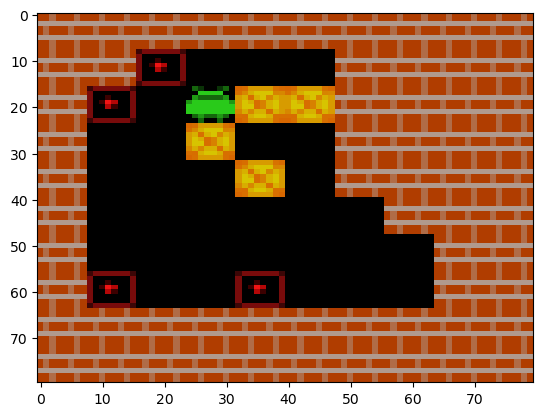

In [17]:
flags.perfect_model = True
flags.stat_type = 2
flags.reward_type = 1
flags.rec_t = 5
flags.reset_m = -1
flags.tree_carry = True
flags.thres_carry = True
flags.thres_discounting = 0.9

raw_env = SokobanWrapper(gym.make("Sokoban-v0"), noop=not flags.env_disable_noop)
raw_obs_shape, num_actions = raw_env.observation_space.shape, raw_env.action_space.n         
model = Model(flags, raw_obs_shape, num_actions=num_actions)
checkpoint = torch.load("../models/model_1.tar")
model.load_state_dict(checkpoint["model_state_dict"])    

env = ModelWrapper(SokobanWrapper(gym.make("Sokoban-v0"), noop=not flags.env_disable_noop), 
     model=model, flags=flags)
env = Environment(env)
obs = env.initial()
plot_obs(env.gym_env.x/255)

=========0========
a_tensor tensor([[[3, 3, 0]]])
eps_step tensor([[51]], dtype=torch.int32)
eps_return tensor([[[-0.1000,  0.0000]]])
reward tensor([[[0., 0.]]])
cur_t tensor([[1]])
thres tensor([0.1688])
root_node qs [tensor([-0.1012]), tensor([-0.1082]), tensor([-0.1150]), tensor([-0.1215])]
child_node qs []
=========1========
a_tensor tensor([[[3, 3, 0]]])
eps_step tensor([[52]], dtype=torch.int32)
eps_return tensor([[[-0.1000,  0.0000]]])
reward tensor([[[0., 0.]]])
cur_t tensor([[2]])
thres tensor([0.1688])
root_node qs [tensor([-0.1012]), tensor([-0.1082]), tensor([-0.1150]), tensor([-0.1215])]
child_node qs []
=========2========
a_tensor tensor([[[3, 3, 0]]])
eps_step tensor([[53]], dtype=torch.int32)
eps_return tensor([[[-0.1000,  0.0000]]])
reward tensor([[[0., 0.]]])
cur_t tensor([[3]])
thres tensor([0.1688])
root_node qs [tensor([-0.1012]), tensor([-0.1082]), tensor([-0.1150]), tensor([-0.1215])]
child_node qs []
=========3========
a_tensor tensor([[[3, 3, 0]]])
eps_step te

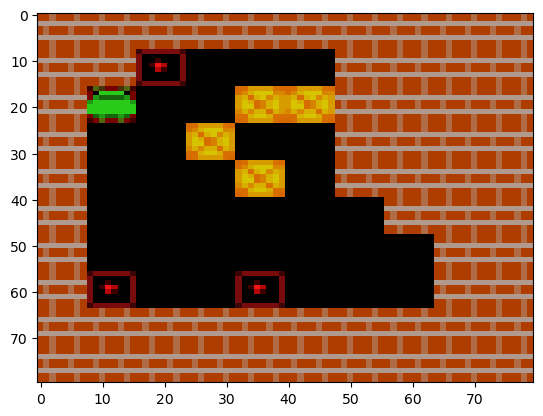

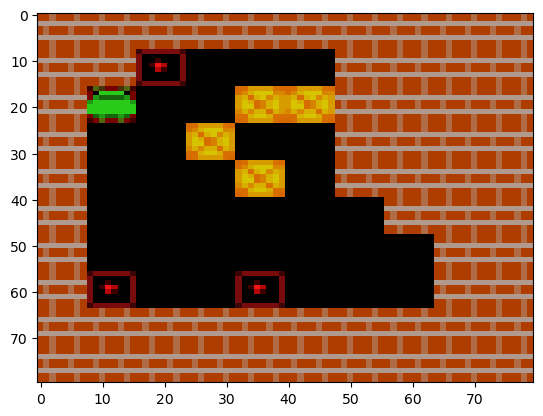

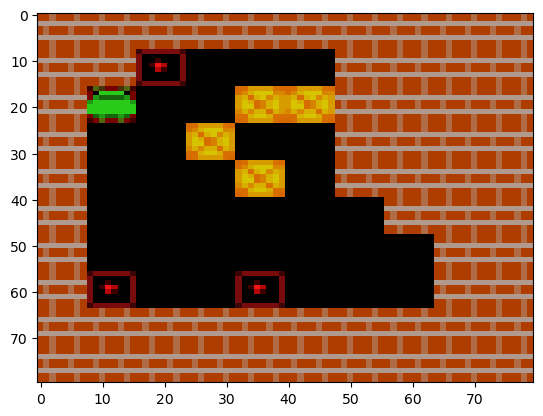

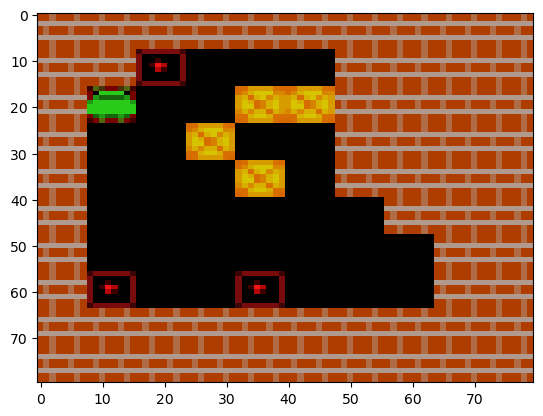

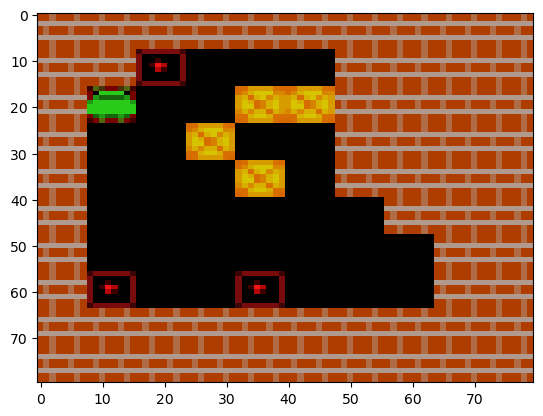

In [28]:
a = 3
a_seqs = ([a,a,0],[a,a,0],[a,a,0],[a,a,0],[a,a,0])

#a_seqs = ([2,4,0],[2,2,0],[2,2,0],[2,2,0],[2,3,0])

for n, a in enumerate(a_seqs):
    print("=========%d========"%n)
    a_tensor = torch.tensor([[a]]).long()
    print("a_tensor", a_tensor)
    obs = env.step(a_tensor)
    print("eps_step", obs['episode_step'])
    print("eps_return", obs['episode_return'])
    print("reward", obs['reward'])
    print("cur_t", obs['cur_t'])
    print("thres", env.gym_env.thres)
    print("root_node qs", [x / 0.97 for x in env.gym_env.root_node.rollout_qs])
    print("child_node qs", env.gym_env.root_node.children[1].rollout_qs)
    plot_obs(env.gym_env.x_/255)

In [ ]:
env.gym_env.root_node.expanded()

In [ ]:
a_seqs = [[0,0,0]]

for n, a in enumerate(a_seqs):
    print("=========%d========"%n)
    a_tensor = torch.tensor([[a]]).long()
    print("a_tensor", a_tensor)
    obs = env.step(a_tensor)
    print("eps_step", obs['episode_step'])
    print("eps_return", obs['episode_return'])
    print("reward", obs['reward'])
    print("cur_t", obs['cur_t'])
    plot_obs(env.gym_env.x_/255)

In [ ]:
env.gym_env.root_node.encoded